In [1]:
import Pkg
Pkg.activate(".");

  Activating project at `~/Documents/MPSTime.jl`


In [127]:
using Plots
using MPSTime
using Random
using StatsBase
using StatsPlots
using Plots.PlotMeasures
using ProgressMeter

# Experiment 1 - Partial Paramter Space Sampling

Setup the model parameters

In [82]:
T = 100 # time series length
n_train = 1000 # number of time series instances
period = 30.0 # fix the period
slope = 0.0 # fix the slope
intervals = 20 # set the number of intervals
phase_train = collect(LinRange(0, 2pi-0.01, intervals))
sigma = 0.05
train, train_info = trendy_sine(T, n_train; period=period, slope=slope, phase=phase_train, sigma=sigma, rng=Xoshiro(12345));

In [97]:
@show countmap(train_info[:period]);
@show countmap(train_info[:slope]);
@show countmap(train_info[:sigma]);

countmap(train_info[:period]) = Dict(30.0 => 1000)
countmap(train_info[:slope]) = Dict(0.0 => 1000)
countmap(train_info[:sigma]) = Dict(0.05 => 1)


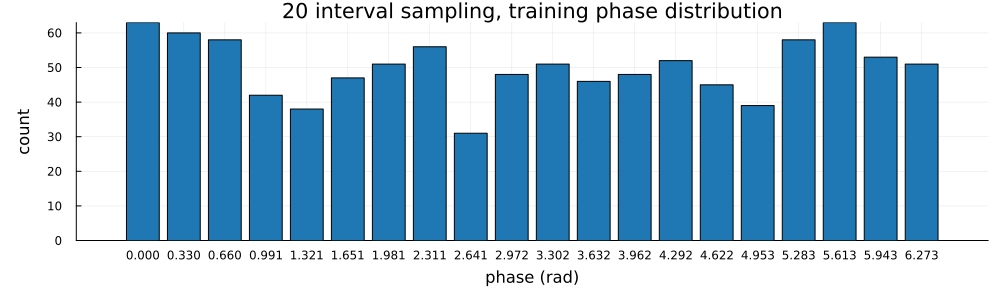

In [98]:
bar(countmap(train_info[:phase]), label="", xlabel="phase (rad)", ylabel="count", xticks=round.(phase; digits=3), size=(1000, 300), bottom_margin=8mm,
    left_margin=8mm, c=palette(:tab10), title="20 interval sampling, training phase distribution")

Test - all paramaters are the same except for the phase, which is now sampled randomly from a uniform distribution $\phi \sim \mathcal{U}(0, 2pi)$

In [85]:
phase_test = (0, 2pi-0.01);
sigma = 0.05
T = 100 # time series length
period = 30.0 # fix the period
slope = 0.0 # fix the slope
n_test = 100
test, test_info = trendy_sine(T, n_test; period=period, slope=slope, phase=phase_test, sigma=sigma, rng=Xoshiro(54321));

In [99]:
@show countmap(train_info[:period]);
@show countmap(train_info[:slope]);
@show countmap(train_info[:sigma]);

countmap(train_info[:period]) = Dict(30.0 => 1000)
countmap(train_info[:slope]) = Dict(0.0 => 1000)
countmap(train_info[:sigma]) = Dict(0.05 => 1)


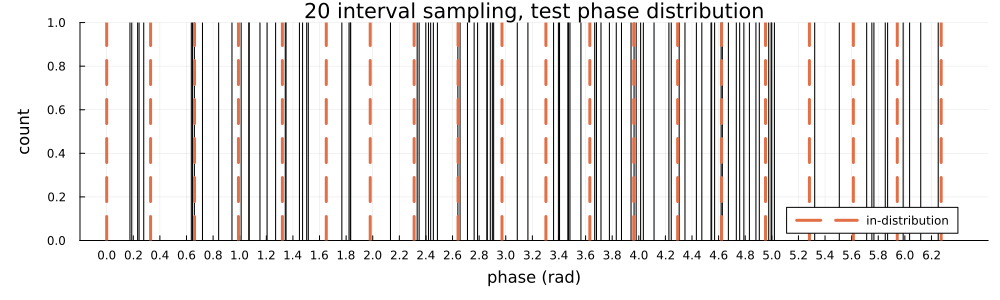

In [124]:
bar(countmap(test_info[:phase]), label="", xlabel="phase (rad)", ylabel="count", xticks=collect(0:0.2:2pi), size=(1000, 300), bottom_margin=8mm,
    left_margin=8mm, c=palette(:tab10), title="20 interval sampling, test phase distribution")
vline!([phase_train], label="in-distribution", lw=3, ls=:dash)

In [128]:
function _make_folds(X::AbstractMatrix, k::Int; rng::Union{Nothing, AbstractRNG}=nothing)
    if isnothing(rng)
        rng = Xoshiro()
    end
    ninstances = size(X, 1)
    X_idxs = randperm(rng, ninstances)
    # split into k folds
    fold_size = ceil(Int, ninstances/k)
    all_folds = [X_idxs[(i-1)*fold_size+1 : min(i*fold_size, ninstances)] for i in 1:k]
    # build pairs
    X_train_idxs = Vector{Vector{Int}}(undef, k)
    X_val_idxs = Vector{Vector{Int}}(undef, k)
    for i in 1:k
        X_val_idxs[i] = all_folds[i]
        X_train_idxs[i] = vcat(all_folds[1:i-1]..., all_folds[i+1:end]...)
    end
    return X_train_idxs, X_val_idxs
end

function make_grid(grid_type::Symbol, sweep_range::Union{Vector{Int}, StepRange}, 
    d_range::Union{Vector{Int}, StepRange}, 
    chi_range::Union{Vector{Int}, StepRange}, 
    eta_range::Union{Vector{Float64}, StepRangeLen}; 
    num_evals::Int=10, 
    rng::Union{AbstractRNG, Nothing}=nothing)

    grid_iter = Iterators.product(sweep_range, d_range, chi_range, eta_range)

    if grid_type == :random
        # check that number of samples is less than exhuastive search
        total_combos = length(grid_iter)
        if num_evals > total_combos
            throw(ArgumentError("Number of evaluations ($num_evals) exceeds total possible hyperparameter combinations ($total_combos)."))
        end
        if rng === nothing
            rng = Xoshiro()
        end
        return sample(rng, collect(grid_iter), num_evals; replace=false)
    elseif grid_type == :exhaustive
        return vcat(grid_iter...)
    else
        throw(ArgumentError("grid type $(str(grid_type)) is not valid. Choose either :random or :exhaustive."))
    end
end

"""
K-fold cross validation for time-series imputation. 
"""
function search_cv_impute(X::Matrix, k::Int, grid_type::Symbol=:random; 
    sweep_range::Union{Vector{Int}, StepRange}, 
    d_range::Union{Vector{Int}, StepRange}, 
    chi_range::Union{Vector{Int}, StepRange}, 
    eta_range::Union{Vector{Float64}, StepRangeLen},
    rng::Union{AbstractRNG, Nothing}=nothing,
    num_models::Int=10,
    pms::Vector{Float64}=collect(0.05:0.2:0.95))

    X_train_idxs, X_val_idxs = _make_folds(X, k; rng=rng)
    param_grid = make_grid(grid_type, sweep_range, d_range, chi_range, eta_range; num_evals=num_models, rng=rng)
    model_scores = Vector{Float64}(undef, length(param_grid)) # holds mean scores across k folds

    # loop over models (parameter combinations)
    for (ipg, (sw, d, chi, eta)) in enumerate(param_grid)
        printstyled("Evaluating model [$ipg/$(length(param_grid))]: $((sw, d, chi, eta))\n"; bold=true, color=:cyan)
        opts = MPSOptions(d=d, chi_max=chi, nsweeps=sw, eta=eta, sigmoid_transform=false, log_level=0);
        model_fold_scores = Vector{Float64}(undef, k) # score for each fold for each model
        for fold in 1:k
            #printstyled("Evaluating fold $fold/$k...\n", color=:red)
            X_train_fold = X[X_train_idxs[fold], :]
            X_val_fold = X[X_val_idxs[fold], :]
            mps = fitMPS(X_train_fold, opts)[1];
            imp = init_imputation_problem(mps, X_val_fold);
            numval = size(X_val_fold, 1)
            instance_scores = Vector{Float64}(undef, numval) # score for each instance across all % missing
            ProgressMeter.@showprogress for inst in eachindex(instance_scores)
                instance_pm_scores_mps = Vector{Float64}(undef, length(pms)) # score for each % missing for a given instance
                for (ipm, pm) in enumerate(pms)
                    impute_sites = mar(X_val_fold[inst, :], pm)[2]
                    stats = MPS_impute(imp, 0, inst, impute_sites, :median; NN_baseline=false, plot_fits=false)[4]
                    instance_pm_scores_mps[ipm] = stats[1][:MAE]
                end
                instance_scores[inst] = mean(instance_pm_scores_mps)
            end
            model_fold_scores[fold] = mean(instance_scores) # mean score across all instances in validation set
        end
        model_scores[ipg] = mean(model_fold_scores) # mean score for given model across all folds
    end
    # get best scoring parameters
    sweeps_best, d_best, chi_best, eta_best = param_grid[argmin(model_scores)]
    best_params = Dict(:nsweeps => sweeps_best, :d => d_best, :chi_max => chi_best, :eta => eta_best)
    return best_params, param_grid, model_scores
end

search_cv_impute

In [143]:
sweep_range = [10, 15, 20, 30] 
d_range = [8, 10]
eta_range = [0.001, 0.01, 0.1, 1.0]
chi_range = [30, 40, 50, 60, 80]
num_models = 2
k = 5 # 5 fold CV
pms = [0.25, 0.5, 0.75];
train_subset = sample(Xoshiro(345), 1:size(train, 1), 100; replace=false)
println("$(length(Iterators.product(sweep_range, d_range, eta_range, chi_range))) possible combinations")

160 possible combinations


In [ ]:
search_cv_impute(train[train_subset, :], k, :random; sweep_range=sweep_range, d_range=d_range, chi_range=chi_range, eta_range=eta_range, rng=Xoshiro(32), num_models=num_models, pms=pms)

Evaluating model [1/2]: (10, 10, 40, 0.01)
Generating initial weight MPS with bond dimension χ_init = 4
        using random state 1234.
Initialising train states.


┌ Warning: Not using MKL BLAS, which may lead to worse performance.
│ To fix this, Import MPSTime into Julia first or use the MKL package
└ @ MPSTime /Users/jmoo2880/Documents/MPSTime.jl/src/Training/RealRealHighDimension.jl:715


blas_name = "LBTConfig([ILP64] libopenblas64_.dylib)"
Using 1 iterations per update.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [1/10]
Backward sweep finished.
Starting forward sweep: [1/10]
Finished sweep 1. Time for sweep: 17.78s
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [2/10]
Backward sweep finished.
Starting forward sweep: [2/10]
Finished sweep 2. Time for sweep: 13.26s
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [3/10]
Backward sweep finished.
Starting forward sweep: [3/10]
Finished sweep 3. Time for sweep: 13.35s
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [4/10]
Backward sweep finished.
Starting forward sweep: [4/10]
Finished sweep 4. Time for sweep: 13.96s
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [5/10]
Backward sweep finished.
Starting forward sweep: [5/10]
Finished sweep 5. Time for sweep: 13.77s
Using opti

Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


Generating initial weight MPS with bond dimension χ_init = 4
        using random state 1234.
Initialising train states.
blas_name = "LBTConfig([ILP64] libopenblas64_.dylib)"
Using 1 iterations per update.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [1/10]
Backward sweep finished.

┌ Warning: Not using MKL BLAS, which may lead to worse performance.
│ To fix this, Import MPSTime into Julia first or use the MKL package
└ @ MPSTime /Users/jmoo2880/Documents/MPSTime.jl/src/Training/RealRealHighDimension.jl:715



Starting forward sweep: [1/10]
Finished sweep 1. Time for sweep: 7.09s
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [2/10]
Backward sweep finished.
Starting forward sweep: [2/10]
Finished sweep 2. Time for sweep: 13.65s
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [3/10]
Backward sweep finished.
Starting forward sweep: [3/10]
Finished sweep 3. Time for sweep: 13.8s
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [4/10]
Backward sweep finished.
Starting forward sweep: [4/10]
Finished sweep 4. Time for sweep: 13.53s
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [5/10]
Backward sweep finished.
Starting forward sweep: [5/10]
Finished sweep 5. Time for sweep: 13.6s
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [6/10]


In [232]:
opts = MPSOptions(d=8, chi_max=80, nsweeps=10, eta=0.01, sigmoid_transform=false)

MPSOptions(1, 10, 80, 0.01, 8, :Legendre_No_Norm, false, 2, 1.0e-10, 1, Float64, :KLD, :TSGO, false, (false, true), false, false, false, true, false, false, 1234, 4, 3, (0.0, 1.0))

In [ ]:
mps, _, _ = fitMPS(train, opts)

Generating initial weight MPS with bond dimension χ_init = 4
        using random state 1234.
Initialising train states.


┌ Warning: Not using MKL BLAS, which may lead to worse performance.
│ To fix this, Import MPSTime into Julia first or use the MKL package
└ @ MPSTime /Users/jmoo2880/Documents/MPSTime.jl/src/Training/RealRealHighDimension.jl:715


blas_name = "LBTConfig([ILP64] libopenblas64_.dylib)"
Using 1 iterations per update.
Training KL Div. 112.40046273919594 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [1/10]
Backward sweep finished.
Starting forward sweep: [1/10]
Finished sweep 1. Time for sweep: 25.35s
Training KL Div. -108.30557464219727 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [2/10]


In [200]:
T = 100 # time series length
n = 100 # number of time series instances
period = 30.0 # fix the period
slope = 1.0 # fix the slope
sigma = 0.0
test, test_info = trendy_sine(T, n; period=period, slope=slope, sigma=sigma, rng=Xoshiro(1674));

In [201]:
imp = init_imputation_problem(mps, test)

Initialising train states.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 500 training samples and 100 testing samples.
Slicing MPS into individual states...
 - 1 class(es) were detected.
 - Time independent encoding - Legendre - detected.
 - d = 8, chi_max = 80
Re-encoding the training data to get the encoding arguments...

 Created 1 ImputationProblem struct(s) containing class-wise mps and test samples.


ImputationProblem(ITensors.ITensorMPS.MPS[ITensors.ITensorMPS.MPS
[1] ((dim=8|id=802|"Site,n=1"), (dim=8|id=377|"Link,l=1"))
[2] ((dim=8|id=491|"Site,n=2"), (dim=8|id=377|"Link,l=1"), (dim=44|id=313|"Link,l=2"))
[3] ((dim=8|id=284|"Site,n=3"), (dim=44|id=313|"Link,l=2"), (dim=80|id=270|"Link,l=3"))
[4] ((dim=8|id=814|"Site,n=4"), (dim=80|id=270|"Link,l=3"), (dim=80|id=275|"Link,l=4"))
[5] ((dim=8|id=933|"Site,n=5"), (dim=80|id=275|"Link,l=4"), (dim=80|id=318|"Link,l=5"))
[6] ((dim=8|id=374|"Site,n=6"), (dim=80|id=318|"Link,l=5"), (dim=80|id=304|"Link,l=6"))
[7] ((dim=8|id=217|"Site,n=7"), (dim=80|id=304|"Link,l=6"), (dim=80|id=872|"Link,l=7"))
[8] ((dim=8|id=511|"Site,n=8"), (dim=80|id=872|"Link,l=7"), (dim=80|id=931|"Link,l=8"))
[9] ((dim=8|id=90|"Site,n=9"), (dim=80|id=931|"Link,l=8"), (dim=80|id=45|"Link,l=9"))
[10] ((dim=8|id=83|"Site,n=10"), (dim=80|id=45|"Link,l=9"), (dim=80|id=379|"Link,l=10"))
[11] ((dim=8|id=729|"Site,n=11"), (dim=80|id=379|"Link,l=10"), (dim=80|id=500|"Link,l

In [219]:
class = 0
pm = 0.3
instance_idx = 2 # time series instance in test set
_, impute_sites = mar(test[instance_idx, :], pm) # simulate MAR mechanism
method = :median

:median

In [220]:
imputed_ts, pred_err, target_ts, stats, plots = MPS_impute(
    imp,
    class, 
    instance_idx, 
    impute_sites, 
    method; 
    NN_baseline=true, # whether to also do a baseline imputation using 1-NNI
    plot_fits=true, # whether to plot the fits
);

In [221]:
stats

1-element Vector{Any}:
 Dict(:MAE => 0.1876268662129925, :MAPE => 0.8652337726861268, :NN_MAE => 0.18362116310957433, :NN_MAPE => 0.7476126244649949)

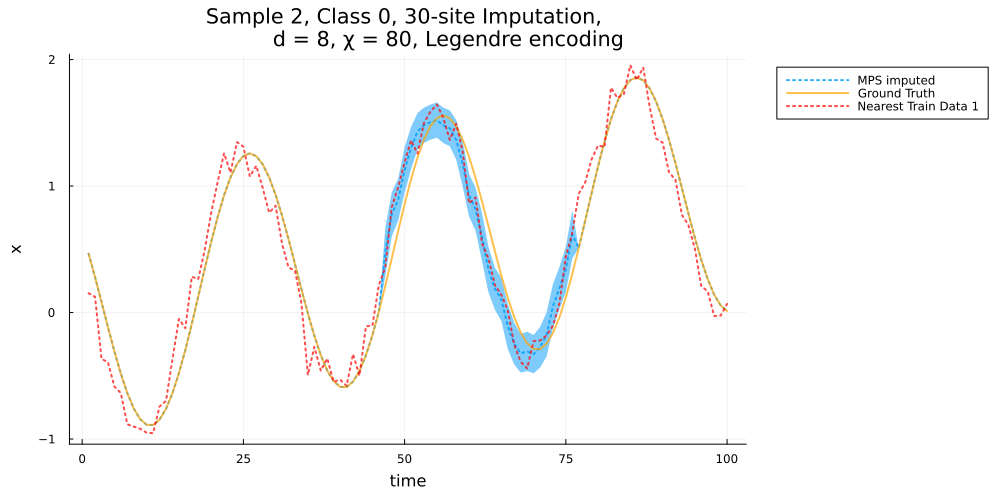

In [222]:
plot(plots...)